# **CLUSTERING MODELS**

This kernel consists of three objectives:
1. Perform exploratory analysis  to extract meaningful insight from the data and identify the best features to be used for  modeling.  

2. Train, test, and refine various clustering models in order to create more explainable people groups. The predictive algorithms to be trained are:
    - K Means
    - Hierarchical
    - DBSCAN
    - HDBSCAN
    - GMM (Gaussian Mixture Models)

### **TRAINING DATA PRE-PROCESSING** 
The first step in the machine learning pipeline is to clean and transform the training data into a useable format for analysis and modeling.   

As such, data pre-processing addresses:
- Assumptions about data shape
- Incorrect data types
- Outliers or errors
- Missing values
- Categorical variables 

In [383]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import umap.umap_ as umap
%matplotlib inline
import sklearn
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
plt.rcParams["figure.figsize"] = [10,5]

In [384]:
# Read data
train_data = pd.read_csv('../data/data.csv')

**Data Shape**  
After loading the dataset, I examine its shape to get a better sense of the data and the information it contains.  

In [385]:
# Data shape
print('train data:',train_data.shape)

train data: (8957, 363)


In [386]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_info_rows', 1000)
pd.set_option('display.width', None)

In [387]:
# View first few rows
train_data.head()

,pseudo_id,today,interviewtype,monitor_gender,interview_province,interview_district,site_001,site_type,assessment_modality,are_you_headhh,respondent_gender,status,province,district,head_age_group,marital_status,widow_o_martyrdom_certi_cate,what_is_your_occupation_what_i,what_is_sizeyour_famil,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,have_children,have_children_001,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,do_you_have_difficul_you_have_1,do_you_have_difficul_using_a__1,do_you_have_difficul_ngclimbi_1,do_you_have_difficul_ingconce_1,do_you_have_difficul_all_verd_1,using_your_usual_cubeing_unde_1,do_you_your_family_m_rotectio_1,psychological_distress,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,children_behaviour,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,oth_members_behaviour,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,health_facility,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,access_health_facility_no,psychological_support,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,access_mhpss_facility_no_001,are_you_currently_receiving_fo,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,wash_access,access_water,do_all_hh_members_h,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,legal_aid_access,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,access_legal,been_able_t_xternal_interference,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,engageexploitative_act,yes_who_boys,yes_wh

In [388]:
# Data Info
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8957 entries, 0 to 8956
Columns: 363 entries, pseudo_id to weight
dtypes: float64(300), int64(1), object(62)
memory usage: 24.8+ MB


**Missing Data**  
From the entry totals above, there appears to be missing data.  A heatmap will help better visualize what features as missing the most information.

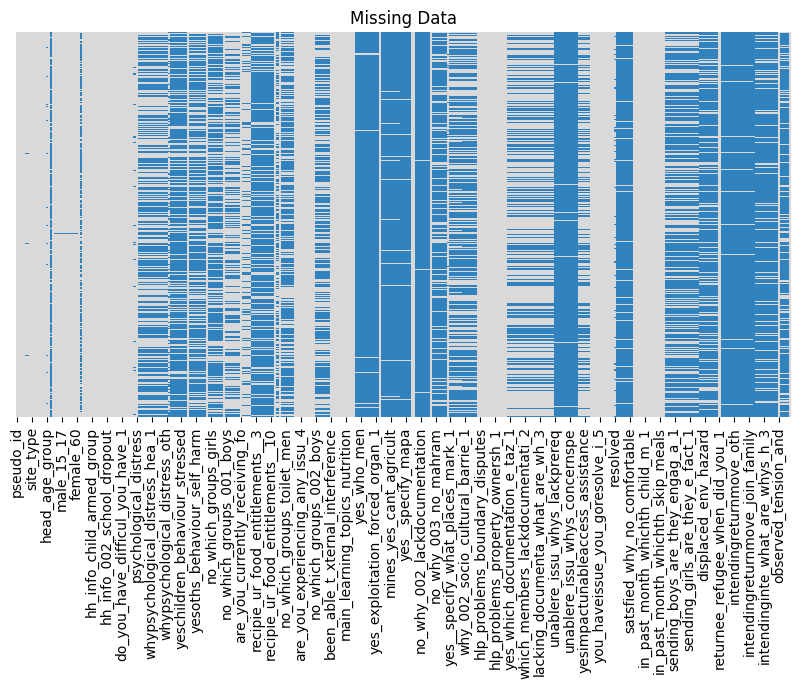

In [389]:
# Heatmap
sns.heatmap(train_data.isnull(),yticklabels = False, cbar = False,cmap = 'tab20c_r')
plt.title('Missing Data')
plt.show()

A lot of columns are full of missing data. But we can't drop most of this columns. This is because this missing data is a meaningful state.

For example, for the column whypsychological_distress_oth:

| Value   | Meaning                                      | Cases    |
| ------- | -------------------------------------------- | -------- |
| 1       | 0 (No)                                       | 4341     |
| 2       | 1 (Yes)                                      | 179      |
| Missing | *(Not asked / Not applicable / No distress)* | **4437** |

In surveys like this:
Missing often means “the question did not apply to the respondent.”

So we can't just drop this kind of columns because we would lose important values.


Besides this, there are some columns that are not useful for model trining. They don't provide any interesting information for us.
- id
- today
- interviewtype
- monitor_gender
- interview_province
- interview_district
- site_001
- assessment_modality

# Categorical Features

In [390]:
print('Non-Null Objects to Be Converted to Category')
print(train_data.select_dtypes(['object']).columns)

Non-Null Objects to Be Converted to Category
Index(['today', 'interviewtype', 'monitor_gender', 'interview_province',
       'interview_district', 'site_001', 'site_type', 'assessment_modality',
       'are_you_headhh', 'respondent_gender', 'status', 'province', 'district',
       'head_age_group', 'marital_status', 'widow_o_martyrdom_certi_cate',
       'what_is_your_occupation_what_i', 'what_is_sizeyour_famil',
       'have_children', 'have_children_001', 'do_you_have_difficul_you_have_1',
       'do_you_have_difficul_using_a__1', 'do_you_have_difficul_ngclimbi_1',
       'do_you_have_difficul_ingconce_1', 'do_you_have_difficul_all_verd_1',
       'using_your_usual_cubeing_unde_1', 'do_you_your_family_m_rotectio_1',
       'psychological_distress', 'children_behaviour', 'oth_members_behaviour',
       'health_facility', 'access_health_facility_no', 'psychological_support',
       'access_mhpss_facility_no_001', 'are_you_currently_receiving_fo',
       'wash_access', 'access_water', '

# Searching relations between different parameters

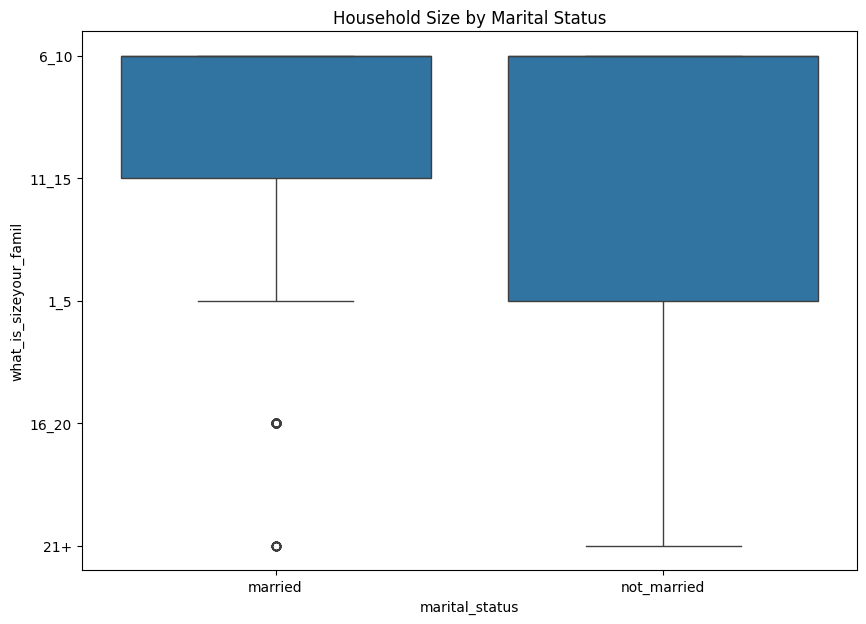

In [391]:
plt.figure(figsize=(10,7))
sns.boxplot(
    x='marital_status',
    y='what_is_sizeyour_famil',
    data=train_data
).set_title('Household Size by Marital Status')
plt.show()

While both married and non-married households commonly range between 6–15 members, extremely large households (21+ members) are observed more frequently among non-married household heads. This suggests extended or dependency-heavy household structures, likely driven by displacement, widowhood, or family aggregation as a coping strategy. These households may require differentiated shelter and support approaches.

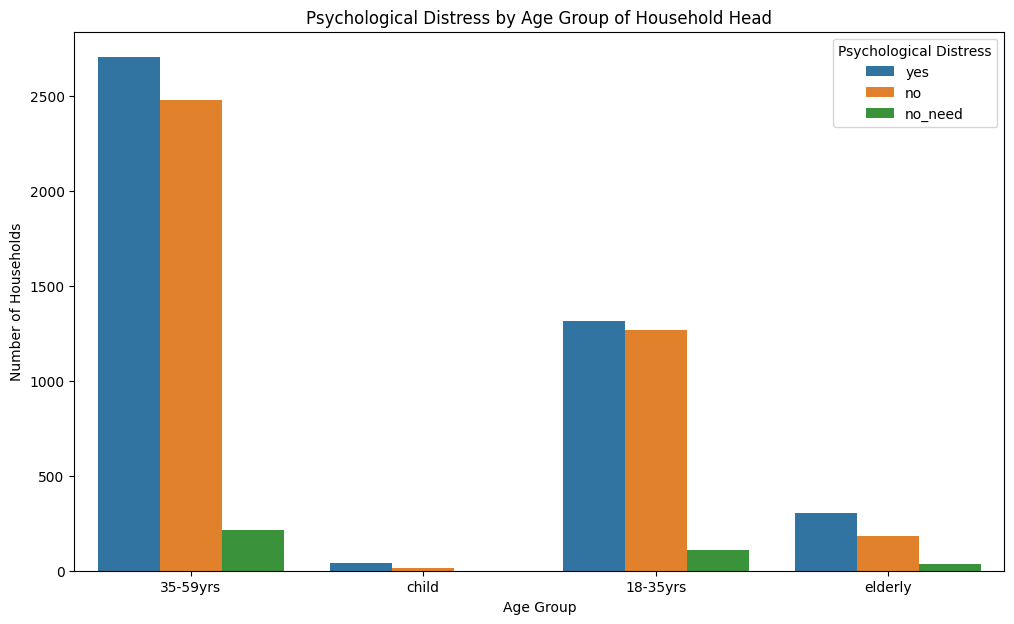

In [392]:
plt.figure(figsize=(12,7))
sns.countplot(
    x='head_age_group',
    hue='psychological_distress',
    data=train_data
)
plt.title('Psychological Distress by Age Group of Household Head')
plt.xlabel('Age Group')
plt.ylabel('Number of Households')
plt.legend(title='Psychological Distress')
plt.show()

Most people report needing psychological support, regardless of age.
Psychological distress is high across all age groups, and no specific age group stands out as having a significantly higher or lower level of distress.

In [393]:
plt.figure(figsize=(120,70))
sns.countplot(
    x='access_health_facility_no',
    hue='psychological_distress',
    data=train_data
)
plt.title('Psychological Distress by Access of health facilities')
plt.xlabel('Access of health facilities')
plt.ylabel('Psychological distress')
plt.legend(title='Psychological Distress')
plt.show()


The majority of people needs psychological help but does not have access to health facilities or the service is just not available.

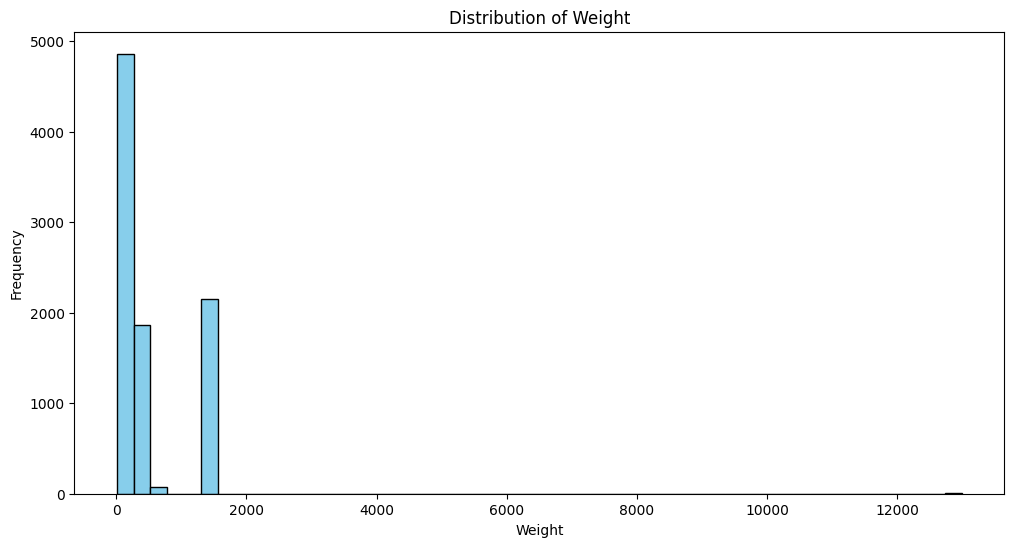

In [394]:
plt.figure(figsize=(12,6))
plt.hist(train_data['weight'].dropna(), bins=50, color='skyblue', edgecolor='black')
plt.title('Distribution of Weight')
plt.xlabel('Weight')
plt.ylabel('Frequency')
plt.show()

Some weight values seem inconsistent, likely because different units of measurement were used.
This is very inconsistent, and we don't have any way to predict what the correct values would be, so we are going to drop the column.

# Preprocessing

### **Categorical Features**

In [395]:
# drop unnecessary columns
train_data = train_data.drop(columns=[
    'pseudo_id', 
    'today', 
    'interviewtype', 
    'monitor_gender', 
    'interview_province', 
    'interview_district', 
    'site_001', 
    'assessment_modality'
])

In [396]:
# Identify categorical features
objects = train_data.select_dtypes(['object']).columns

# Convert categorical variables into 'dummy' or indicator variables
for object_ in objects:
    pd.get_dummies(train_data[object_], drop_first = True)

train_data = pd.get_dummies(train_data, drop_first=True)
train_data.head(1)

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,yes_who_boys,yes_who_girls,yes_who_men,yes_who_women,yes_exploitation_labour,yes_exploitation_sexual,yes_exploitation_forced_criminal,yes_exploitation_domestic,yes_exploitation_forced_drug,yes_exploitation_forced_organ_1,mines_yes_children_play,mines_yes_children_school,mines_yes_cant_access_services,mines_yes_cant_colect_water,mines_yes_cant_agricult,mines_yes_cant_graze_animals,mines_yes_oth,no_why_002_discr_exmahr,no_why_002_no_mahram,no_why_002_lackdocumentation,no_why_002_fear_personal_safety,no_why_002_safety_concerns_re_1,no_why_002_presenceexplosive__1,no_why_002_oth,no_why_003_discr_exmahr,no_why_003_no_mahram,no_why_003_lackdocumentation,no_why_003_fear_personal_safety,no_why_003_safety_concerns_re_1,no_why_003_presenceexplosive__1,no_why_003_oth,yes__specify_what_places_mark_1,yes__specify_what_places_wate_1,yes__specify_what_places_scho_1,yes__specify_what_places

In [397]:
# These columns must be 0 if they are not answered
count_cols = [
    'male_0_6','male_7_14','male_15_17','male_18_59','male_60',
    'female_0_6','female_7_14','female_15_17','female_18_59','female_60'
]
train_data[count_cols] = train_data[count_cols].fillna(0)

# NaN to 0
float_cols = train_data.select_dtypes(include='float64').columns
train_data[float_cols] = train_data[float_cols].fillna(0.0)

In [398]:
train_data = train_data.drop(columns=['weight'])

We will interpret NaN values as unanswered responses. This approach gives more emphasis to positive answers.

In [399]:
train_data.head()

,male_0_6,male_7_14,male_15_17,male_18_59,male_60,female_0_6,female_7_14,female_15_17,female_18_59,female_60,hh_info_person_health,hh_info_legal_needs,hh_info_school_dropout,hh_info_unable_work,hh_info_child_armed_group,hh_info_family_unity,hh_info_drug_dependence,hh_info_none,hh_info_oth,hh_info_002_person_health,hh_info_002_legal_needs,hh_info_002_school_dropout,hh_info_002_unable_work,hh_info_002_child_armed_group,hh_info_002_family_unity,hh_info_002_drug_dependence,hh_info_002_none,hh_info_002_oth,whypsychological_distress_con_1,whypsychological_distress_com_1,whypsychological_distress_fam_1,whypsychological_distress_out_1,whypsychological_distress_den_1,whypsychological_distress_chi_1,whypsychological_distress_hea_1,whypsychological_distress_den_2,whypsychological_distress_abuse,whypsychological_distress_ear_1,whypsychological_distress_lac_1,whypsychological_distress_foo_1,whypsychological_distress_eco_1,whypsychological_distress_oth,yeschildren_behaviour_withdrawn,yeschildren_behaviour_violent_1,yeschildren_behaviour_eating__1,yeschildren_behaviour_self_harm,yeschildren_behaviour_sad,yeschildren_behaviour_stressed,yeschildren_behaviour_suicida_1,yeschildren_behaviour_oth,yesoths_behaviour_withdrawn,yesoths_behaviour_violent_agg_1,yesoths_behaviour_eating_diso_1,yesoths_behaviour_self_harm,yesoths_behaviour_sad,yesoths_behaviour_stressed,yesoths_behaviour_suicidal_te_1,yesoths_behaviour_oth,no_which_groups_boys,no_which_groups_girls,no_which_groups_men,no_which_groups_women,no_which_groups_elder,no_which_groups_disability,no_which_groups_001_boys,no_which_groups_001_girls,no_which_groups_001_men,no_which_groups_001_women,no_which_groups_001_elder,no_which_groups_001_disability,you_are_not_a_ben_is_why_it_n_1,you_are_not_a_ben_is_why_it_n_2,you_are_not_a_ben_is_why_it_n_3,you_are_not_a_ben_is_why_it_n_4,recipie_ur_food_entitlements__1,recipie_ur_food_entitlements__2,recipie_ur_food_entitlements__3,recipie_ur_food_entitlements__4,recipie_ur_food_entitlements__5,recipie_ur_food_entitlements__6,recipie_ur_food_entitlements__7,recipie_ur_food_entitlements__8,recipie_ur_food_entitlements__9,recipie_ur_food_entitlements__10,recipie_ur_food_entitlements_oth,no_which_groups_toilet_boys,no_which_groups_toilet_girls,no_which_groups_toilet_men,no_which_groups_toilet_women,no_which_groups_toilet_elder,no_which_groups_toilet_disabi_1,are_you_experiencing_any_issu_1,are_you_experiencing_any_issu_2,are_you_experiencing_any_issu_3,are_you_experiencing_any_issu_4,are_you_experiencing_any_issu_5,are_you_experiencing_any_issu_6,are_you_experiencing_any_issu_7,are_you_experiencing_any_issu_8,are_you_experiencing_any_issu_9,no_which_groups_002_boys,no_which_groups_002_girls,no_which_groups_002_men,no_which_groups_002_women,no_which_groups_002_elder,no_which_groups_002_disability,main_learning_topics_access,main_learning_topics_housing,main_learning_topics_complaint,main_learning_topics_document_1,main_learning_topics_cash,main_learning_topics_disability,main_learning_topics_nutrition,main_learning_topics_agriculture,main_learning_topics_eligibility,main_learning_topics_oth,yes_who_boys,yes_who_girls,yes_who_men,yes_who_women,yes_exploitation_labour,yes_exploitation_sexual,yes_exploitation_forced_criminal,yes_exploitation_domestic,yes_exploitation_forced_drug,yes_exploitation_forced_organ_1,mines_yes_children_play,mines_yes_children_school,mines_yes_cant_access_services,mines_yes_cant_colect_water,mines_yes_cant_agricult,mines_yes_cant_graze_animals,mines_yes_oth,no_why_002_discr_exmahr,no_why_002_no_mahram,no_why_002_lackdocumentation,no_why_002_fear_personal_safety,no_why_002_safety_concerns_re_1,no_why_002_presenceexplosive__1,no_why_002_oth,no_why_003_discr_exmahr,no_why_003_no_mahram,no_why_003_lackdocumentation,no_why_003_fear_personal_safety,no_why_003_safety_concerns_re_1,no_why_003_presenceexplosive__1,no_why_003_oth,yes__specify_what_places_mark_1,yes__specify_what_places_wate_1,yes__specify_what_places_scho_1,yes__specify_what_places

>Now the data is perfect for a machine learning algorithm:  
- all the data is numeric
- everything is concatenated together

## **MACHINE LEARNING**
Next, we will feed these features into various algorithms to determine the best performance using a simple framework.

- K Means
- Hierarchical
- DBSCAN
- HDBSCAN
- GMM (Gaussian Mixture Models)

First, we will split the data: 75% for training and 25% for testing.

In [428]:
from sklearn.model_selection import train_test_split

# Split data
train_df, test_df = train_test_split(train_data, test_size=0.25, random_state=42)
train_df.to_csv('../data/train_data.csv', index=False)
test_df.to_csv('../data/test_data.csv', index=False)

# K Means

In [438]:
dfkmean = train_df

scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfkmean)

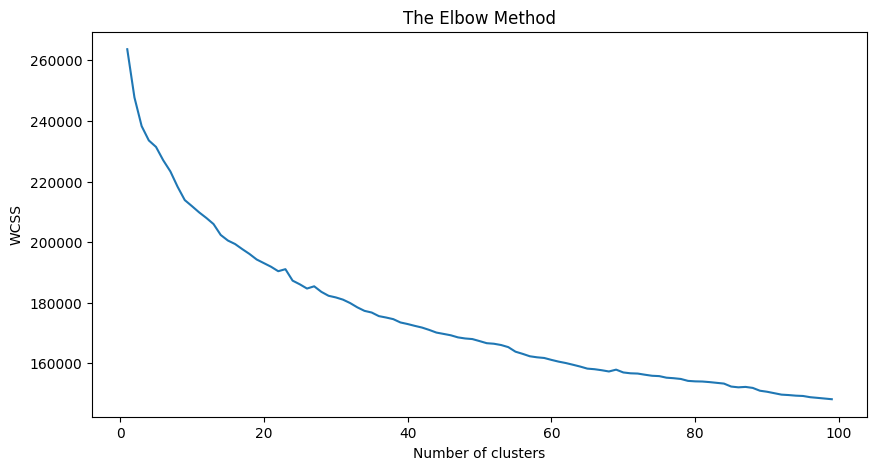

In [440]:
from sklearn.cluster import KMeans
wcss = []
for i in range(1, 100):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(dfkmean)
    wcss.append(kmeans.inertia_)
plt.plot(range(1, 100), wcss)
plt.title('The Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

In [444]:
n_clusters = 34

Using the elbow method, we analyze how the within-cluster sum of squares (WCSS) changes as the number of clusters increases in the KMeans model. 

At first, adding clusters significantly reduces WCSS, but after a certain point the improvement becomes marginal. The optimal number of clusters is identified where this reduction starts to slow down noticeably, forming an “elbow” in the curve. 

In our case, this elbow appears between 3 and 4 clusters, and additional tests indicate that 4 clusters provides the best balance between model simplicity and cluster quality.

In [441]:
try:
    reducer = umap.UMAP(
        n_components=2,
        n_neighbors=30,
        min_dist=0.1,
        metric='euclidean',
        random_state=42,
        verbose=True
    )
    embedding = reducer.fit_transform(X_scaled)
    dfkmean = pd.DataFrame(X_scaled, columns=dfkmean.columns[3:5])
    dfkmean['umap1'] = embedding[:, 0]
    dfkmean['umap2'] = embedding[:, 1]
except Exception as e:
    print("Couldn't use UMAP 2D:", e)
    dfkmean['umap1'] = X_scaled[:, 0]
    dfkmean['umap2'] = X_scaled[:, 1]


UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Wed Dec 17 20:18:40 2025 Construct fuzzy simplicial set
Wed Dec 17 20:18:40 2025 Finding Nearest Neighbors
Wed Dec 17 20:18:40 2025 Building RP forest with 9 trees
Wed Dec 17 20:18:40 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Wed Dec 17 20:18:42 2025 Finished Nearest Neighbor Search
Wed Dec 17 20:18:42 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec 17 20:19:31 2025 Finished embedding
Couldn't use UMAP 2D: Shape of passed values is (6717, 500), indices imply (6717, 2)


In [442]:
dfkmean['cluster'] = y_kmeans

In [445]:
kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

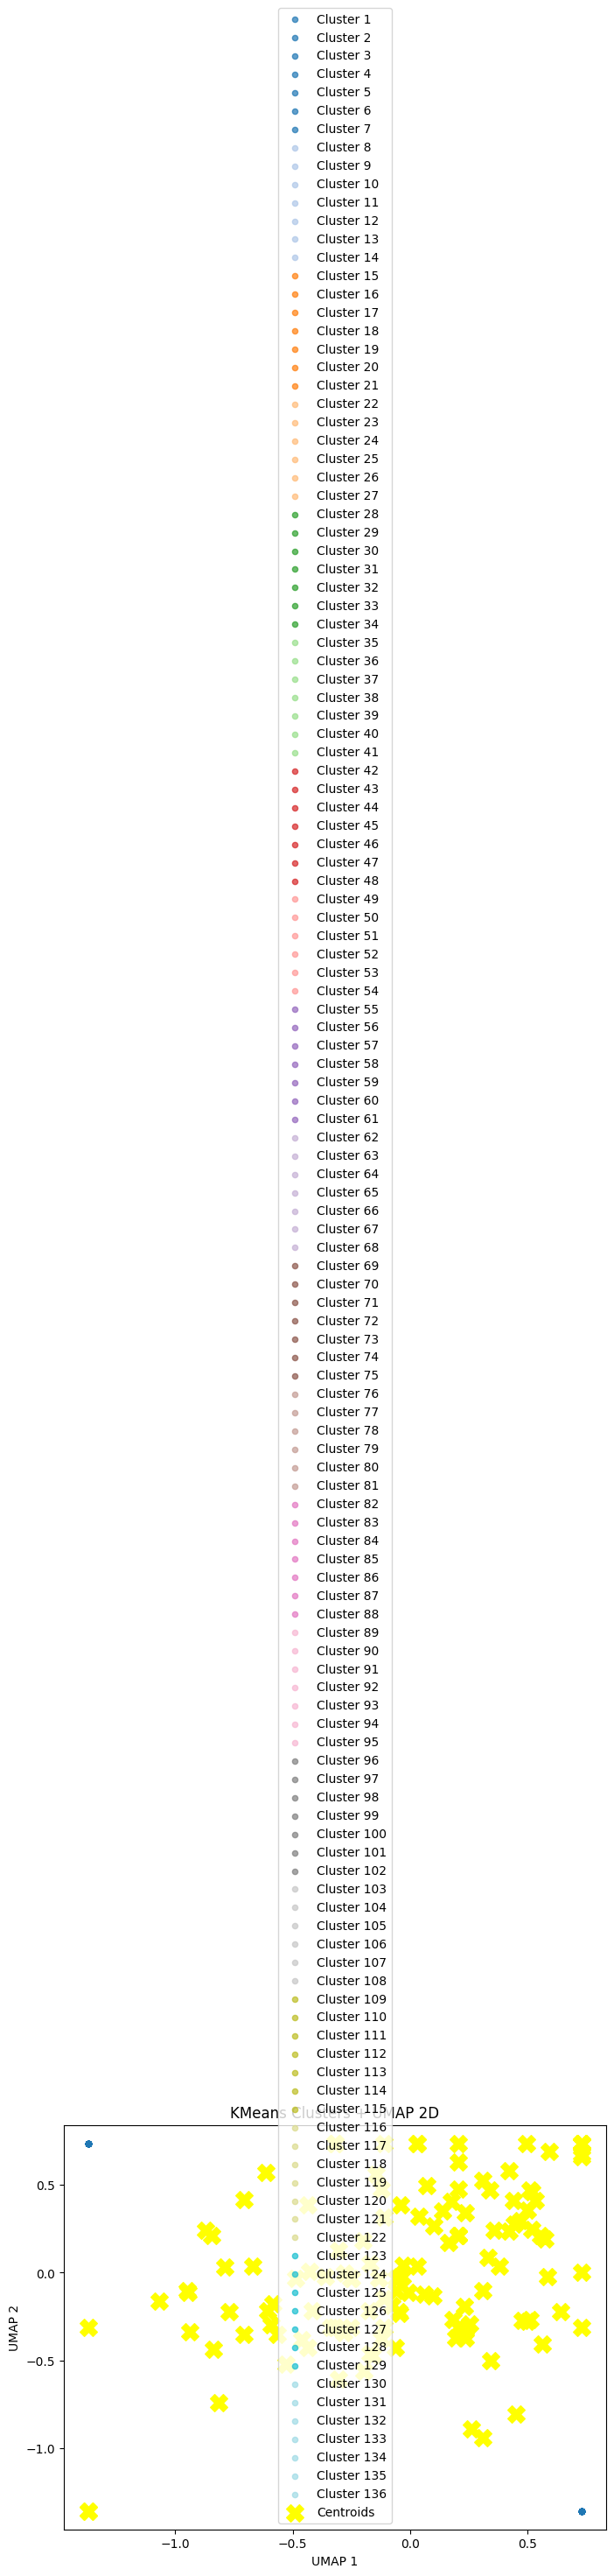

In [ ]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap

kmeans = KMeans(n_clusters=n_clusters, init='k-means++', random_state=42)
y_kmeans = kmeans.fit_predict(X_scaled)

plt.figure(figsize=(8, 6))
cmap = plt.cm.get_cmap('tab20', n_clusters)  # similar a DBSCAN plot

# Plot clusters
for i in range(n_clusters):
    plt.scatter(
        dfkmean.loc[dfkmean['cluster'] == i, 'umap1'],
        dfkmean.loc[dfkmean['cluster'] == i, 'umap2'],
        s=20,
        label=f'Cluster {i+1}',
        alpha=0.7,
        c=[cmap(i)]
    )

# Plot centroids
centroids_umap = kmeans.cluster_centers_
plt.scatter(
    centroids_umap[:, 0],
    centroids_umap[:, 1],
    s=200,
    c='yellow',
    label='Centroids',
    marker='X'
)

plt.xlabel('UMAP 1')
plt.ylabel('UMAP 2')
plt.title('KMeans Clusters + UMAP 2D')
plt.legend()
plt.show()


KMeans is not suitable for this project because it assumes clusters are spherical and of similar size, and it relies on minimizing variance around cluster centers. Our data likely has irregularly shaped clusters with varying densities, which KMeans cannot capture accurately. Methods like HDBSCAN are better for detecting non-uniform, dense regions, giving a more realistic clustering.

# Hierarchical

In [ ]:
from sklearn.preprocessing import StandardScaler

dfhierarchical = train_df

X = dfhierarchical.iloc[:, [3, 4]].values
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [408]:
import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

In [409]:
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

silhouette_scores = []
cluster_range = range(2, 21)

for k in cluster_range:
    model = AgglomerativeClustering(
        n_clusters=k,
        linkage='ward'
    )
    labels = model.fit_predict(X_umap)
    score = silhouette_score(X_umap, labels)
    silhouette_scores.append(score)

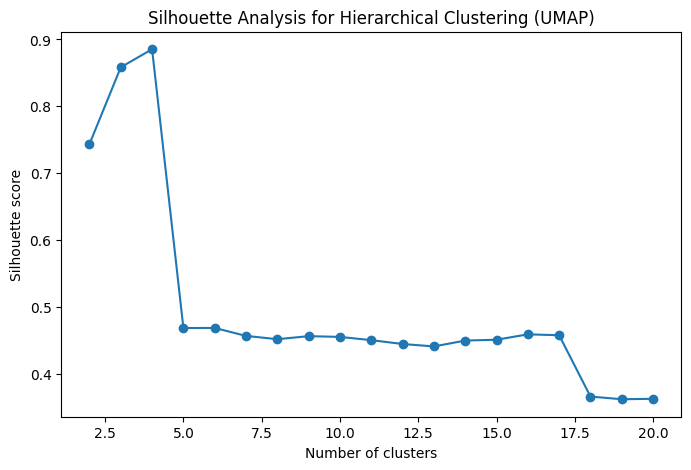

In [410]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))
plt.plot(cluster_range, silhouette_scores, marker='o')
plt.xlabel("Number of clusters")
plt.ylabel("Silhouette score")
plt.title("Silhouette Analysis for Hierarchical Clustering (UMAP)")
plt.show()

In [411]:
best_k = cluster_range[silhouette_scores.index(max(silhouette_scores))]
print("Best number of clusters:", best_k)

Best number of clusters: 4


This method uses silhouette analysis to determine the optimal number of clusters for the model by evaluating how well each data point fits within its assigned cluster compared to others.

In [412]:
from sklearn.cluster import AgglomerativeClustering

hierarchical = AgglomerativeClustering(
    n_clusters=best_k,
    linkage='ward'
)

cluster_labels = hierarchical.fit_predict(X_umap)

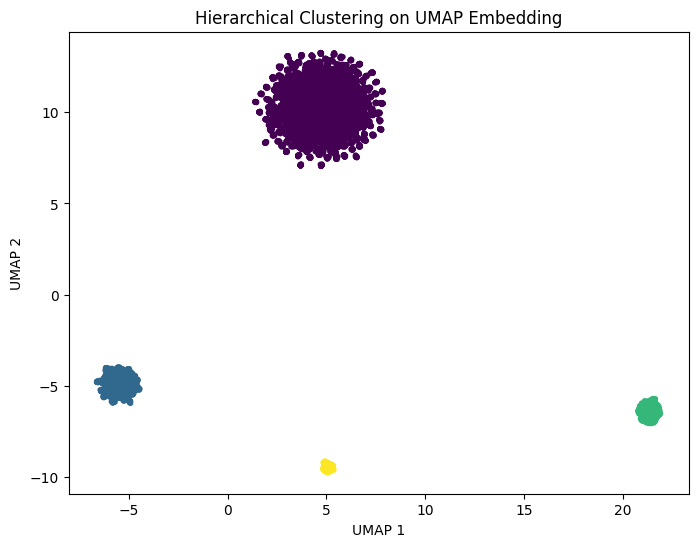

In [413]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=cluster_labels,
    s=10
)
plt.title("Hierarchical Clustering on UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


Although the clustering evaluation indicates that 4 clusters provide the best statistical separation, this result mainly captures the global structure of the data and is too coarse for the objectives of this project. 

Our goal is to identify more detailed population groups in order to better support the selection and design of suitable shelters. 

Therefore, we will explore and compare different clustering models to determine whether alternative approaches can provide more useful and actionable groupings for this purpose.

# DBSCAN

In [431]:
dfdbscan = train_df

scaler = StandardScaler()
X_scaled = scaler.fit_transform(dfdbscan)

In [432]:
import umap

umap_model = umap.UMAP(
    n_neighbors=15,
    min_dist=0.1,
    n_components=2,
    random_state=42
)

X_umap = umap_model.fit_transform(X_scaled)

In [433]:
from sklearn.cluster import DBSCAN

# Example: start with a candidate epsilon
dbscan_model = DBSCAN(
    eps=0.5,        # will tune this
    min_samples=5
)

dbscan_labels = dbscan_model.fit_predict(X_umap)

In [434]:
n_clusters = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print("Estimated number of clusters:", n_clusters)
print("Number of noise points:", n_noise)

Estimated number of clusters: 34
Number of noise points: 0


In [435]:
from sklearn.metrics import silhouette_score

best_eps = None
best_score = -1
eps_values = np.linspace(0.1, 1.5, 15)  # adjust range if needed

for eps in eps_values:
    model = DBSCAN(eps=eps, min_samples=5)
    labels = model.fit_predict(X_umap)
    
    # Only calculate silhouette if at least 2 clusters
    n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
    if n_clusters > 1:
        score = silhouette_score(X_umap, labels)
        if score > best_score:
            best_score = score
            best_eps = eps

print("Best eps:", best_eps)
print("Best silhouette score:", best_score)

Best eps: 0.1
Best silhouette score: 0.5711798667907715


In [436]:
final_dbscan = DBSCAN(eps=best_eps, min_samples=5)
final_labels = final_dbscan.fit_predict(X_umap)

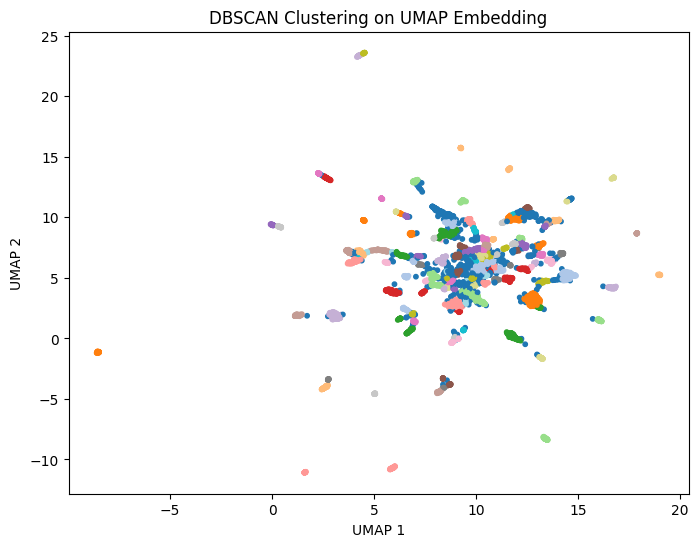

In [437]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(
    X_umap[:, 0],
    X_umap[:, 1],
    c=final_labels,
    s=10,
    cmap='tab20'
)
plt.title("DBSCAN Clustering on UMAP Embedding")
plt.xlabel("UMAP 1")
plt.ylabel("UMAP 2")
plt.show()


# HDBSCAN

In [421]:
import hdbscan

In [422]:
scaler = StandardScaler()
dfhdbscan = train_df
X_scaled = scaler.fit_transform(dfhdbscan)

We need to reduce dimensionality to plot the clusters.
PCA would be a good tool for this. But since this is linear, we are using UMAP better.

### Optimal configuration
Lets search whats the optimal configuration for our HDBSCAN model now

In [423]:
param_grid = {
    'min_cluster_size': [10, 12, 14, 16, 18, 20],
    'min_samples': [1, 3, 5, 8]
}

In [424]:
from itertools import product
from sklearn.metrics import silhouette_score
import hdbscan
import pandas as pd
import numpy as np

param_grid = {
    'min_cluster_size': [10, 12, 14, 16],
    'min_samples': [1, 3, 5]
}

results = []

for mcs, ms in product(param_grid['min_cluster_size'], param_grid['min_samples']):
    clusterer = hdbscan.HDBSCAN(min_cluster_size=mcs, min_samples=ms)
    labels = clusterer.fit_predict(X_scaled)
    
    mask = labels != -1
    if mask.sum() == 0:
        continue
    
    score = silhouette_score(embedding[mask], labels[mask])
    results.append({'min_cluster_size': mcs, 'min_samples': ms, 'silhouette': score})

results_df = pd.DataFrame(results)
print(results_df.sort_values('silhouette', ascending=False))

    min_cluster_size  min_samples  silhouette
8                 14            5   -0.528042
11                16            5   -0.540669
10                16            3   -0.562881
7                 14            3   -0.578775
5                 12            5   -0.582747
6                 14            1   -0.600812
9                 16            1   -0.601788
2                 10            5   -0.605204
4                 12            3   -0.609195
1                 10            3   -0.610453
3                 12            1   -0.628875
0                 10            1   -0.632160


Seems that the best optimal solution is reached with (min cluster size: 14, min samples: 5)

In [425]:
clusterer = hdbscan.HDBSCAN(min_cluster_size=14, min_samples=5)
labels = clusterer.fit_predict(X_scaled)
dfhdbscan['cluster'] = labels

In [426]:
try:
    reducer = umap.UMAP(n_components=2,
                       n_neighbors=30,
                       min_dist=0.1,
                       metric='euclidean',
                       random_state=42,
                       verbose=True)
    embedding = reducer.fit_transform(X_scaled)
    dfhdbscan['umap1'] = embedding[:, 0]
    dfhdbscan['umap2'] = embedding[:, 1]
except Exception as e:
    print("Couldn't use Umap 2D:", e)
    dfhdbscan['umap1'] = X_scaled[:, 0]
    dfhdbscan['umap2'] = X_scaled[:, 1]

UMAP(n_jobs=1, n_neighbors=30, random_state=42, verbose=True)
Wed Dec 17 20:10:25 2025 Construct fuzzy simplicial set
Wed Dec 17 20:10:25 2025 Finding Nearest Neighbors
Wed Dec 17 20:10:25 2025 Building RP forest with 9 trees
Wed Dec 17 20:10:26 2025 NN descent for 13 iterations
	 1  /  13
	 2  /  13
	 3  /  13
	 4  /  13
	 5  /  13
	Stopping threshold met -- exiting after 5 iterations
Wed Dec 17 20:10:28 2025 Finished Nearest Neighbor Search
Wed Dec 17 20:10:28 2025 Construct embedding


Epochs completed:   0%|            0/500 [00:00]

	completed  0  /  500 epochs
	completed  50  /  500 epochs
	completed  100  /  500 epochs
	completed  150  /  500 epochs
	completed  200  /  500 epochs
	completed  250  /  500 epochs
	completed  300  /  500 epochs
	completed  350  /  500 epochs
	completed  400  /  500 epochs
	completed  450  /  500 epochs
Wed Dec 17 20:11:07 2025 Finished embedding


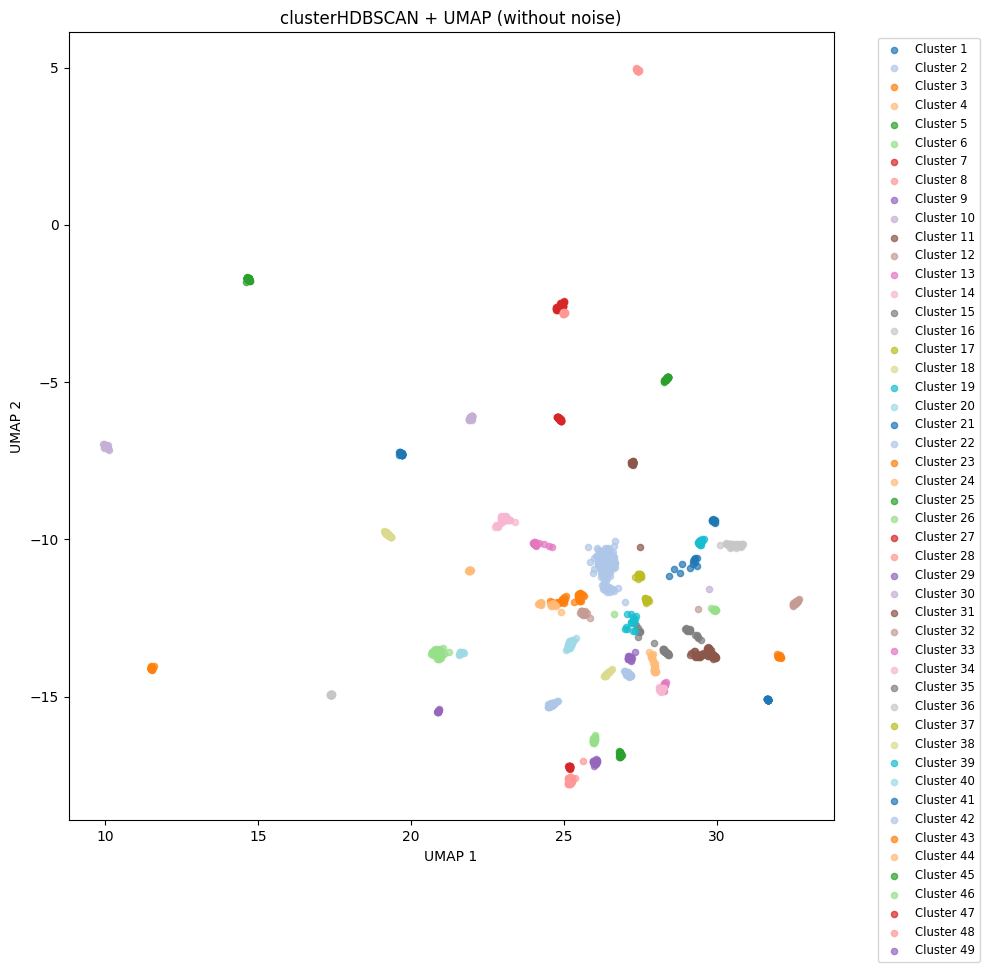

In [427]:
plt.figure(figsize=(10, 10))

show_noise = False # We are turning this off to see the clusters more clearly

cluster_ids = [c for c in np.unique(dfhdbscan['cluster']) if (c != -1 or show_noise)]

if show_noise and (-1 in np.unique(dfhdbscan['cluster'])):
    cluster_ids = sorted(np.unique(dfhdbscan['cluster']))
else:
    cluster_ids = [c for c in sorted(np.unique(dfhdbscan['cluster'])) if c != -1]

n_clusters = len([c for c in cluster_ids if c != -1])

if n_clusters == 0:
    print("No clusters found.")
else:
    cmap = plt.cm.get_cmap('tab20')
    cluster_map = {orig_id: i for i, orig_id in enumerate([c for c in cluster_ids if c != -1])}

    for orig_cluster in cluster_ids:
        mask = dfhdbscan['cluster'] == orig_cluster
        if orig_cluster == -1:
            color = (0.7, 0.7, 0.7)
            label = 'Noise'
            alpha = 0.25
            s = 8
        else:
            idx = cluster_map[orig_cluster]
            color = cmap(idx % 20)
            label = f'Cluster {idx + 1}'
            alpha = 0.7
            s = 20

        plt.scatter(dfhdbscan.loc[mask, 'umap1'], dfhdbscan.loc[mask, 'umap2'],
                    color=color, label=label, alpha=alpha, s=s)

    plt.xlabel('UMAP 1')
    plt.ylabel('UMAP 2')
    plt.title('cluster' + 'HDBSCAN + UMAP (without noise)' if not show_noise else 'cluster' + 'HDBSCAN + UMAP (with noise)')
    plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
    plt.tight_layout()
    plt.show()